In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import math



# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Define improved transformations - less aggressive augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),  # No random crop for validation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load dataset
train_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/train", transform=transform_train)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

validation_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/validation", transform=transform_val)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [3]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        
        # Initial feature extraction
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Convolutional blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )

        # Squeeze-and-excitation blocks
        self.se1 = SEBlock(128)
        self.se2 = SEBlock(256)
        self.se3 = SEBlock(512)

        # Shortcut projections for residual connections
        self.shortcut1 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        self.shortcut2 = nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False)

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        # Initial features
        x = self.initial(x)

        # Residual block 1 with SE
        identity1 = self.shortcut1(x)
        x = self.conv1(x)
        x = self.se1(x)
        x = x + identity1

        # Residual block 2 with SE
        identity2 = self.shortcut2(x)
        x = self.conv2(x)
        x = self.se2(x)
        x = x + identity2

        # Residual block 3 with SE
        x = self.conv3(x)
        x = self.se3(x)

        # Global pooling and classification
        x = self.avgpool(x)
        x = self.fc(x)
        return x


Starting training...
Epoch: 1
Epoch 1/100, Train Loss: 1.8148, Train Accuracy: 24.61%
Current learning rate: 0.001000
Validation Loss: 1.9225, Validation Accuracy: 26.42%
Epoch: 2
Epoch 2/100, Train Loss: 1.6803, Train Accuracy: 33.53%
Current learning rate: 0.001000
Validation Loss: 1.5061, Validation Accuracy: 41.95%
Epoch: 3
Epoch 3/100, Train Loss: 1.5591, Train Accuracy: 40.02%
Current learning rate: 0.001000
Validation Loss: 1.6022, Validation Accuracy: 37.72%
Epoch: 4
Epoch 4/100, Train Loss: 1.5111, Train Accuracy: 42.44%
Current learning rate: 0.001000
Validation Loss: 1.3866, Validation Accuracy: 47.52%
Epoch: 5
Epoch 5/100, Train Loss: 1.4746, Train Accuracy: 44.21%
Current learning rate: 0.001000
Validation Loss: 1.3749, Validation Accuracy: 47.88%
Epoch: 6
Epoch 6/100, Train Loss: 1.4462, Train Accuracy: 45.38%
Current learning rate: 0.001000
Validation Loss: 1.3337, Validation Accuracy: 50.58%
Epoch: 7
Epoch 7/100, Train Loss: 1.4128, Train Accuracy: 46.92%
Current learni

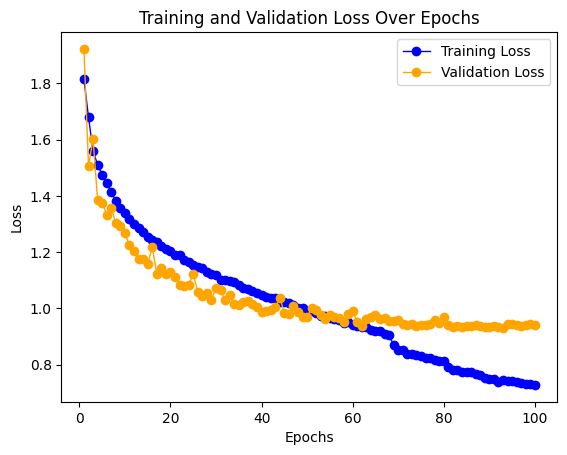

Training complete!
Final Validation Accuracy: 71.70%


In [6]:
# Initialize model, loss, and optimizer
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.03)  # Apply label smoothing
# criterion = FocalLoss(alpha=0.25, gamma=2)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Scheduler setup
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-6)

# Mixed precision scaler
scaler = torch.amp.GradScaler("cuda")

train_losses = []
val_losses = []

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Validation loss calculation
def compute_validation_loss():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loaded_validation:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loaded_validation)

# Training function
def train_part(model, optimizer, epochs=10):
    model = model.to(device)
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}")
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for images, labels in loaded_train:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()

            # Mixed precision training
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

        # Calculate accuracy
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(loaded_train):.4f}, Train Accuracy: {accuracy:.2f}%")
        print(f"Current learning rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

        # Compute validation loss and update scheduler
        val_loss = compute_validation_loss()
        scheduler.step(val_loss)
        train_losses.append(running_loss / len(loaded_train))
        val_losses.append(val_loss)
        val_accuracy = evaluate_model(model, loaded_validation)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Plot training and validation losses
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color='blue', linewidth=1, marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color='orange', linewidth=1, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.show()


print("Starting training...")
train_part(model, optimizer, epochs=100)
print("Training complete!")

# Final validation accuracy
val_accuracy = evaluate_model(model, loaded_validation)
print(f'Final Validation Accuracy: {val_accuracy:.2f}%')

Target label: happy


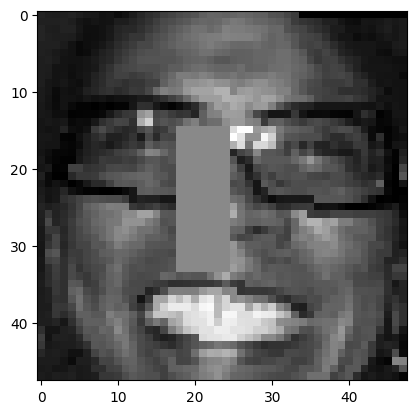

In [7]:
# Visualization setup
dataiter = iter(loaded_train)
images, labels = next(dataiter)
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display a random image and its label
random_idx = random.randint(0, 63)
print("Target label:", expression[int(labels[random_idx].cpu().numpy())])
plt.imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()


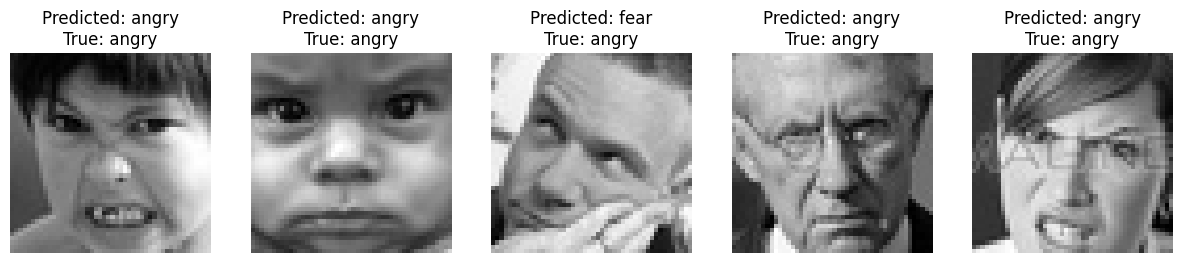

In [8]:
# Evaluate the model and make predictions on 5 random images
model.eval()
dataiter = iter(loaded_validation)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display 5 random images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_idx = random.randint(0, len(images) - 1)
    axes[i].imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Predicted: {expression[int(predicted[random_idx].cpu().numpy())]}\nTrue: {expression[int(labels[random_idx].cpu().numpy())]}")
    axes[i].axis('off')
plt.show()